 **Goal:** : In this project we are implementing a multi-agent envoronment in which an agent tries to reach a goal while an enemy tries to avoid that 

Define the envoironment 

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import imageio, io
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from tqdm import tqdm
from shapely.geometry import Polygon

# Azioni: [Up, Down, Left, Right]
actions = {0:(0, -1), 1 : (0, 1), 2: (-1, 0), 3:(1, 0)}
action_names = {0: "Up", 1: "Down", 2: "Left", 3: "Right"}

class AdversarialEnvironment:
    def __init__(self, 
                 width, 
                 height, 
                 border = 1, 
                 move_penalty = -0.1, 
                 goal_reward = 10, 
                 enemy_reward = 10, 
                 fail_penalty = -10, 
                 seed = None, 
                 num_obstacles = 0, 
                 enhanced = True,
                 max_bonus = 0,
                 bonus_growth = 0, 
                 mobile_goal = False,
                 enemy_enalbled = False,
                 fully_competitive = False):

        self.width = width
        self.height = height
        self.border_size = border
        self.board = np.zeros((self.width + 2 * self.border_size, self.height + 2 * self.border_size, 3), dtype = np.float32)
        self.reward = 0
        self.done = False

        self.move_penalty = move_penalty
        self.goal_reward = goal_reward
        self.enemy_reward = enemy_reward
        self.fail_penalty = fail_penalty

        self.num_obstacles = num_obstacles
        self.enhanced = enhanced # to add info about the near obstacles

        self.bonus_growth = bonus_growth
        self.bonus = np.zeros((height,width)) + max_bonus
        self.max_bonus = max_bonus
        self.mobile_goal = mobile_goal
        self.enemy_enabled = enemy_enalbled

        self.agent_pos = [0, 0]
        self.enemy_pos = [0 , self.height  - 1 ]  if self.enemy_enabled else None
        self.goal_pos = [random.randint(0 + self.width//2, self.width - 1 ), random.randint(0 + self.height//2, self.height - 1 )]

        # Define a seed to reproduce the same environment
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        self.obstacles = self.create_obstacles(self.num_obstacles)
        self.frames = []
        self.fully_competitive = fully_competitive

    # Generate random obstacles
    def create_obstacles(self, num_obstacles):
        obstacles = []
        for _ in range(num_obstacles):
            while True:

                # Avoid obstacles too near to the agent starting point
                x = random.randint(2, self.width - 1)
                y = random.randint(2, self.height -1)
                obstacle = (x, y)

                # Avoid obstacles near the agent, enemy and goal
                if self.enemy_enabled:
                    
                    if obstacle != tuple(self.agent_pos) and obstacle != tuple(self.goal_pos) and  (obstacle != tuple(self.enemy_pos)):
                        obstacles.append(obstacle)
                        break
                else:
                    if obstacle != tuple(self.agent_pos) and obstacle != tuple(self.goal_pos):
                        obstacles.append(obstacle)
                        break
        return obstacles


    def reset(self):
        
        self.bonus[:,:] =  self.max_bonus 
        self.reward = 0
        self.done = False
        self.agent_pos = [0, 0]   
        self.enemy_pos = [0 , self.height  - 1 ]  if self.enemy_enabled else None
        
        while True:
            self.goal_pos = [random.randint(0 + self.width//2, self.width - 1),
                             random.randint(0 + self.height//2, self.height - 1)]
            if tuple(self.goal_pos) not in self.obstacles:
                break
      
        return self.get_state(), self.reward, self.done
    
    # Move the agent in the given direction, return True if the move is valid and False otherwise
    def move_agent(self, action): 
        direction = actions[action]
        new_pos = [self.agent_pos[0] + direction[0], self.agent_pos[1] + direction[1]]

        if 0 <= new_pos[0] < self.width and 0 <= new_pos[1] < self.height and tuple(new_pos) not in self.obstacles:
            self.agent_pos = new_pos
            return True
               
        return True

    def move_enemy(self, action):
        direction = actions[action]
        new_pos = [self.enemy_pos[0] + direction[0], self.enemy_pos[1] + direction[1]]

        if 0 <= new_pos[0] < self.width  and 0 <= new_pos[1] < self.height and tuple(new_pos) not in self.obstacles: 
            self.enemy_pos = new_pos
            return True
        
        return True

    def move_goal(self):
        direction = random.choice(actions)
        new_pos = [self.goal_pos[0] + direction[0], self.goal_pos[1] + direction[1]]

        if 0 <= new_pos[0] < self.width and 0 <= new_pos[1] < self.height and tuple(new_pos) not in self.obstacles:
            self.goal_pos = new_pos


    def is_near_wall_or_obstacle(self, pos, direction, is_enemy = False):
        new_pos = [pos[0] + direction[0], pos[1] + direction[1]]

        if not (0 <= new_pos[0] < self.width and 0 <= new_pos[1] < self.height) or tuple(new_pos) in self.obstacles:
            return 1        

        return 0 

    # Get the state to feed to the networks
    def get_state(self):

        if not self.enhanced:      
            return self.agent_pos  + self.goal_pos + self.enemy_enabled * self.enemy_pos
        else:
            # Add to the state the information about the near obstacles for the agent
            agent_near_up = self.is_near_wall_or_obstacle(self.agent_pos, actions[0])  # Su
            agent_near_down = self.is_near_wall_or_obstacle(self.agent_pos, actions[1])  # Giù
            agent_near_left = self.is_near_wall_or_obstacle(self.agent_pos, actions[2])  # Sinistra
            agent_near_right = self.is_near_wall_or_obstacle(self.agent_pos, actions[3])  # Destra
            
            state = self.agent_pos + self.goal_pos + [agent_near_up, agent_near_down, agent_near_left, agent_near_right]

            if not self.enemy_enabled:  
                return state
            else: 
                # Add to the state the information about the near obstacles for the enemy
                enemy_near_up = self.is_near_wall_or_obstacle(self.enemy_pos, actions[0], is_enemy=True)  # Su
                enemy_near_down = self.is_near_wall_or_obstacle(self.enemy_pos, actions[1], is_enemy= True  )  # Giù
                enemmy_near_left = self.is_near_wall_or_obstacle(self.enemy_pos, actions[2], is_enemy = True)  # Sinistra
                enemy_near_right = self.is_near_wall_or_obstacle(self.enemy_pos, actions[3], is_enemy = True) # Destra

                return state + self.enemy_pos + [enemy_near_up, enemy_near_down, enemmy_near_left, enemy_near_right]
            
    
    def step(self, agent_action, enemy_action = None, goal_distance_penalty = False):

        # Check if the moves are admissible
        admissible_move_agent = self.move_agent(agent_action)
        admissible_move_enemy = self.move_enemy(enemy_action) if self.enemy_enabled else True

        if goal_distance_penalty:
            penalty = - 0.1 * np.log(np.sum(np.abs(np.array(self.agent_pos) - np.array(self.goal_pos)) ))
        else:
            penalty = self.move_penalty

        if self.mobile_goal:
            self.move_goal()

        # Check if the agent reached the goal
        if admissible_move_agent and self.agent_pos == self.goal_pos:
            reward = self.goal_reward
            enemy_reward = self.fail_penalty if self.enemy_enabled else None
            self.done = True
            truncated = False
            return self.board_state(), self.get_state(), reward, enemy_reward, truncated, self.done
        
        # Check if the enemy reached the agent
        if admissible_move_enemy and self.enemy_pos == self.agent_pos:
            reward = self.fail_penalty
            enemy_reward = self.enemy_reward
            self.done = True
            truncated = False
            return self.board_state(), self.get_state(), reward, enemy_reward, truncated, self.done
        
        # Check if the agent or the enemy hit an obstacle
        if not admissible_move_agent or not admissible_move_enemy:
            reward = self.fail_penalty if not admissible_move_agent else penalty
            enemy_reward = self.fail_penalty if not admissible_move_enemy else (- reward if self.full_competitive else self.move_penalty)
            self.done = True
            truncated = True
            return self.board_state(), self.get_state(), reward, enemy_reward, truncated, self.done
        
        # If both moves are valid and no one reached a terminal condition
        reward = penalty #self.move_penalty
        enemy_reward = self.move_penalty if self.enemy_enabled else None #self.move_penalty
        truncated = False
        self.done = False

        # Update bonuses
        x_agent, y_agent = self.agent_pos
        reward += self.bonus[x_agent, y_agent]
        self.bonus[x_agent, y_agent] = 0

        if self.enemy_enabled:
            x_enemy, y_enemy = self.enemy_pos
            enemy_reward += self.bonus[x_enemy, y_enemy]
            self.bonus[x_enemy, y_enemy] = 0

        self.bonus += self.bonus_growth
        self.bonus[self.bonus > self.max_bonus] = self.max_bonus

        if self.fully_competitive:
            enemy_reward = - reward

        return self.board_state(), self.get_state(), reward, enemy_reward , truncated, self.done
        
    def board_state(self):
        
        # Reset the board
        self.board = np.zeros((self.width + 2 * self.border_size, 
                    self.height + 2 * self.border_size, 3), dtype = np.float32)
        
        self.board[:, :self.border_size] = [0.5, 0.5, 0.5]  # Left border
        self.board[:, -self.border_size:] = [0.5, 0.5, 0.5]  # Right border
        self.board[:self.border_size, :] = [0.5, 0.5, 0.5]  # Top border
        self.board[-self.border_size:, :] = [0.5, 0.5, 0.5]  # Bottom border

        # Consider the obstacles
        for (x, y) in self.obstacles:
            if 0 <= x < self.width and 0 <= y < self.height:
                self.board[y + self.border_size, x + self.border_size] = [0.5, 0.5, 0.5]  # Grigio per gli ostacoli

        # Locate the agent, the enemy and the goal
        self.board[self.agent_pos[1] + self.border_size, self.agent_pos[0] + self.border_size] = [1, 1, 0]  # -> Yellow for agent
        self.board[self.goal_pos[1] + self.border_size, self.goal_pos[0] + self.border_size] = [0, 1, 0]  # -> Green for goal
        if self.enemy_enabled:
            self.board[self.enemy_pos[1] + self.border_size, self.enemy_pos[0] + self.border_size] = [1, 0, 0]  # -> Red for enemy

        return self.board

    def render(self, pause = 0.1, text = None, save_gif = False):
        clear_output(wait = True) 

        plt.figure(figsize=(self.width, self.height))

        plt.imshow(self.board_state(), interpolation = "none")
        
        plt.text(self.agent_pos[0] + self.border_size, self.agent_pos[1] + self.border_size,"A", fontsize = 10, ha = "center", va = "center", color = "black")
        plt.text(self.goal_pos[0] + self.border_size, self.goal_pos[1] + self.border_size, "G", fontsize = 10, ha = "center", va = "center", color = "black")
        if self.enemy_enabled: 
            plt.text(self.enemy_pos[0] + self.border_size, self.enemy_pos[1] + self.border_size, "E", fontsize = 10, ha = "center", va = "center", color = "black")

        for obs in self.obstacles:
            plt.text(obs[0] + self.border_size, obs[1] + self.border_size, "X", fontsize = 10, ha = "center", va = "center", color = "black", backgroundcolor = "gray")

        plt.title('Agent = A (Yellow), Enemy = E (Red), Goal = G (Green), Obstacles = X (Gray)', color = 'black', fontsize = 10)
        
        if text is not None:
            plt.gca().text(1, 1, text, fontsize = 15, color = 'yellow')
        
        plt.axis('off')

        if save_gif:
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            self.frames.append(imageio.imread(buf))

        plt.pause(pause)  
        plt.close()

    def save_gif(self, filename = "animation.gif", fps = 5):
        imageio.mimsave(filename, self.frames, fps = fps)  # Salva la GIF dai frame

In [26]:
def adversarial_demo(actions_agent, actions_enemy):

    env = AdversarialEnvironment(10,10, border=1, num_obstacles=10, seed = 42, enhanced = True, mobile_goal=True, enemy_enalbled=False)

    for i in range(len(actions_agent)):
        
        if env.enemy_enabled:
            board, state, reward, enemy_reward, truncated, done = env.step(actions_agent[i], actions_enemy[i], goal_distance_penalty= False)
        else:
            board, state, reward, enemy_reward, truncated, done = env.step(actions_agent[i], goal_distance_penalty= False)

        env.render(pause = 0.1, save_gif = True, text = f"Step: {i+1}, Reward: {reward, enemy_reward}, Position: {env.agent_pos}, {env.get_state()}") 
        
        if done or truncated:

            if env.enemy_enabled == True and env.agent_pos == env.enemy_pos:
                print("Enemy caught the Agent!")
            if env.agent_pos == env.goal_pos:
                print("Agent reached the Goal!")
            break

    env.save_gif("adversarial_demo.gif")
    


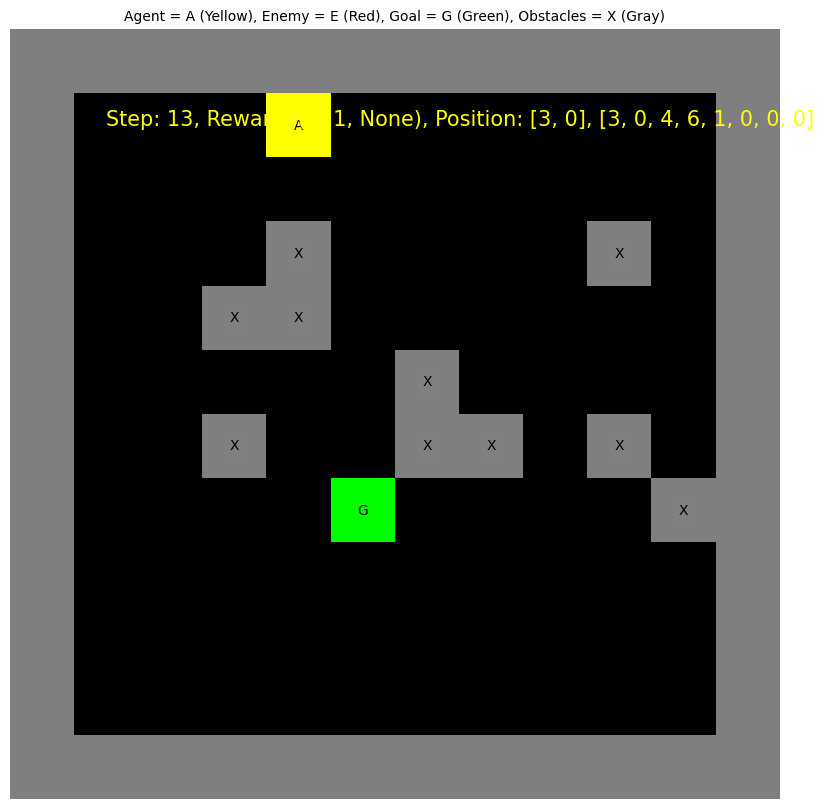

In [27]:
steps = 15
actions_agent = np.concatenate((np.full(8,0) , np.full(3,3), np.full(2,0)),0)
print(actions_agent)
actions_enemy = np.random.randint(0,4, size = steps)  # Esempio di azioni del nemico
adversarial_demo(actions_agent, actions_enemy)


Define the network

In [28]:
# MLP network with 2 hidden layers
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size = [64, 128]):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], action_size)
        self.relu = nn.ReLU()
    
    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Implement the replay buffer, with option for prioritized experience replay

In [29]:
import numpy as np
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity, prioritized = True, alpha = 0.6, beta = 0.4):
        self.capacity = capacity
        self.prioritized = prioritized
        self.alpha = alpha
        self.beta = beta
        self.beta_min = beta
        self.memory = deque(maxlen = capacity)
        self.priorities = deque(maxlen = capacity)
    
    def __len__(self):
        return len(self.memory)
        
    def add(self, experience, td_error):
        if self.prioritized:
            priority = (abs(td_error) + 1e-5) ** self.alpha  # Prioritize the experience based on the TD error
            self.memory.append(experience)
            self.priorities.append(priority)
        else:
            self.memory.append(experience)
    
    def sample(self, batch_size):

        if not self.prioritized:
            return random.sample(self.memory, batch_size), None, None
        
        # Compute the sampling probabilities
        probs = np.array(self.priorities) / np.sum(self.priorities) 
        indices = np.random.choice(len(self.memory), batch_size, p = probs) # Sample indices based on the probabilities
        samples = [self.memory[idx] for idx in indices]
        
        # Compute the importance sampling weights used to correct the bias introduced by prioritized experience replay
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize the weights
        
        return samples, indices, weights
    
    def update_priority(self, index, td_error):
        self.priorities[index] = (abs(td_error) + 1e-5) ** self.alpha

    # Linearly anneal beta from beta_min to 1 over the course of total_episodes
    def update_beta(self, episode, total_episodes):
        self.beta = min(1.0, self.beta_min + (1.0 - self.beta_min) * (episode / total_episodes))

Define a class to handle the agent's behavior

In [69]:
from tqdm.notebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Agente DQN
class DQNAgents:
    def __init__(self,
                 state_size,
                 action_size,
                 buffer_size = 100_000,
                 gamma = 0.99, 
                 epsilon = 1.0, 
                 epsilon_min = 0.05, 
                 epsilon_decay = 0.995, 
                 learning_rate = 5e-6,
                 prioritized = True,
                 enemy_enabled = True,
                 indipendent_learning = False):
        
        self.state_size = state_size  
        self.action_size = action_size  

        self.memory = ReplayBuffer(buffer_size, prioritized = prioritized) 

        # Learning parameters
        self.gamma = gamma  
          
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.learning_type = 'indipendent' if indipendent_learning else 'global'
        self.enemy_enabled = enemy_enabled

        # Indipendent Learning
        if self.learning_type == 'indipendent':
            # Define the networks for the agent
            self.agent_policy_network = DQN(self.state_size, self.action_size).to(self.device)
            self.agent_target_network = DQN(self.state_size, self.action_size).to(self.device)
            self.agent_epsilon = epsilon

            self.agent_target_network.load_state_dict(self.agent_policy_network.state_dict())
            self.agent_target_network.eval()

            if self.enemy_enabled:
                # Define the netowrks for the enemy
                self.enemy_policy_network = DQN(self.state_size, self.action_size).to(self.device)
                self.enemy_target_network = DQN(self.state_size, self.action_size).to(self.device)
                self.enemy_epsilon = epsilon

                self.enemy_target_network.load_state_dict(self.enemy_policy_network.state_dict())
                self.enemy_target_network.eval()

        # Global Learning
        else:
            if self.enemy_enabled:

                # If the enemy is enabled, the Q-values are represented as a matrix of action_size x action_size
                total_action_size = self.action_size**2 
            else:
                total_action_size = self.action_size

            self.epsilon = epsilon

            # Define a unique policy and target network for both the agent and the enemy
            self.policy_network = DQN(self.state_size, total_action_size).to(self.device)
            self.target_network = DQN(self.state_size, total_action_size).to(self.device)

            self.target_network.load_state_dict(self.policy_network.state_dict())
            self.target_network.eval()
        
        self.target_update_freq = 50

        self.criterion = nn.HuberLoss() # Loss function

        if self.learning_type == 'global':
            self.optimizer = optim.AdamW(self.policy_network.parameters(), lr = self.learning_rate, amsgrad = True)
            self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size = 100 , gamma = 0.9)
        else:
            self.agent_optimizer = optim.AdamW(self.agent_policy_network.parameters(), lr = self.learning_rate, amsgrad = True)
            self.agent_scheduler = lr_scheduler.StepLR(self.agent_optimizer, step_size = 100, gamma = 0.9)
            
            if self.enemy_enabled:
                self.enemy_optimizer = optim.AdamW(self.enemy_policy_network.parameters(), lr = self.learning_rate, amsgrad = True)
                self.enemy_scheduler = lr_scheduler.StepLR(self.enemy_optimizer, step_size = 100, gamma = 0.9)
 

    def remember(self, experience, td_error = None):
        self.memory.add(experience, td_error)

    def update_target_network(self, episode, enemy_training = False):

        if self.target_update_freq > 0 and episode % self.target_update_freq == 0 :

            if self.learning_type == 'indipendent':
                if not enemy_training:
                # When the enemy is enabled, we update both the agent and the enemy target networks
                    self.agent_target_network.load_state_dict(self.agent_policy_network.state_dict())
                if self.enemy_enabled and enemy_training:
                    self.enemy_target_network.load_state_dict(self.enemy_policy_network.state_dict())
            else:
                self.target_network.load_state_dict(self.policy_network.state_dict())
    
    # Update the epsilon value for epsilon-greedy exploration
    def update_epsilon(self, enemy_training = False):
        if self.learning_type == 'indipendent':
            if not enemy_training:
                if self.agent_epsilon > self.epsilon_min:
                    self.agent_epsilon *= self.epsilon_decay
                else:
                    self.agent_epsilon = self.epsilon_min
            else:
                if self.enemy_epsilon > self.epsilon_min:
                    self.enemy_epsilon *= self.epsilon_decay
                else:
                    self.enemy_epsilon = self.epsilon_min
        else:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min

    def update_lr(self, enemy_training = False):
        if self.learning_type == 'global':
            self.scheduler.step()
        else:
            if not enemy_training:
                self.agent_scheduler.step()
            else:
                self.enemy_scheduler.step()
            

    # Select the action to perform based on the epsilon-greedy
    def epsilon_greedy_action(self, state, dim = None, agent_action = None, enemy_training = False):
        
        # Choose a random action with probability epsilon

        if self.learning_type == 'global':
           
            epsilon = self.epsilon
        else:   
            if not enemy_training:
                epsilon = self.agent_epsilon
            else:
                epsilon = self.enemy_epsilon
        
        if np.random.rand() <= epsilon:
            action = random.randint(0, self.action_size - 1)

        # Exploit the policy with probability 1 - epsilon
        else:
            
            with torch.no_grad():

                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            
                # Global learning
                if self.learning_type == 'global':
                    q_values = self.policy_network(state) # Compute the Q-values
                   
                    # If the enemy is enabled, the Q-values are represented as a matrix
                    if self.enemy_enabled:

                        q_values_matrix = q_values.view(-1, self.action_size, self.action_size)

                        if dim == 2 and agent_action is None:

                            action = torch.argmax(torch.min(q_values_matrix, dim=dim)[0]).item()  # Agent's min-max action
                           
                        # If we are selecting the enemy's action (minimizing the agent's reward given agent's action)
                        elif dim == 1 and agent_action is not None:
                            
                            q_values_given_agent = q_values_matrix[:, agent_action, :].squeeze()
                            
                            # choose the action that minimizes the agent's reward
                            action = torch.argmin(q_values_given_agent).item()
                        
                        
                        elif dim == 1 and agent_action is None:
                           
                            action = torch.argmax(torch.min(-1* q_values_matrix, dim = 1)[0]).item()  # Enemy's min-max action with - Q
                            

                    else:
                        # If no enemy is present, just consider the action based on the max Q-value
                        action = torch.argmax(q_values).item()

                # Indipendent learning
                else:
                    if dim == 2:
                        # Choose the action for the agent
                        q_values = self.agent_policy_network(state)
                       
                    elif dim == 1:
                        # Choose the action for the enemy
                        q_values = self.enemy_policy_network(state)
                    
                    action = torch.argmax(q_values).item()
                        
        return action

    def act_agent(self, state):
        return self.epsilon_greedy_action(state, dim = 2)

    def act_enemy(self, state, agent_action = None, enemy_training = False):
        return self.epsilon_greedy_action(state, dim = 1, agent_action = agent_action, enemy_training= enemy_training)

    def replay(self, batch_size, enemy_training = False):
 
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)

        minibatch, indices, weights = self.memory.sample(batch_size)

        
        state_batch, agent_action_batch, enemy_action_batch, agent_reward_batch, enemy_reward_batch, next_state_batch, done_batch = zip(*minibatch)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        agent_action_batch = torch.tensor(agent_action_batch).to(self.device)  
        agent_reward_batch = torch.FloatTensor(agent_reward_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device) 
        done_batch = torch.FloatTensor(done_batch).to(self.device)

        # Global learning 
        if self.learning_type == 'global':

            if self.enemy_enabled:
                enemy_action_batch = torch.tensor(enemy_action_batch).to(self.device)
                enemy_reward_batch = torch.FloatTensor(enemy_reward_batch).to(self.device)

            agent_q_values_batch = self.policy_network(state_batch)
            
            # When the enemy is enabled, the Q-values are represented as a matrix
            if self.enemy_enabled:

                agent_q_values_matrix = agent_q_values_batch.view(-1, self.action_size, self.action_size)
                agent_action_batch = agent_action_batch.unsqueeze(1).unsqueeze(2)  
                enemy_action_batch = enemy_action_batch.unsqueeze(1).unsqueeze(2)  

                agent_q_values_batch = agent_q_values_matrix.gather(1, agent_action_batch.expand(-1, 1, self.action_size))  
                agent_q_values_batch = agent_q_values_batch.gather(2, enemy_action_batch).squeeze()  
            
            # Without enemy, just consider the agent's action
            else:
                agent_q_values_batch = agent_q_values_batch.gather(1, agent_action_batch.view(-1,1)).squeeze()       

        # Indipendent learning
        else:
            if not enemy_training:
                agent_q_values_batch = self.agent_policy_network(state_batch)
                agent_q_values_batch = agent_q_values_batch.gather(1, agent_action_batch.view(-1,1)).squeeze()

            if self.enemy_enabled and enemy_training:

                enemy_action_batch = torch.tensor(enemy_action_batch).to(self.device)
                enemy_reward_batch = torch.FloatTensor(enemy_reward_batch).to(self.device)
                
                enemy_q_values_batch = self.enemy_policy_network(state_batch)
                enemy_q_values_batch = enemy_q_values_batch.gather(1, enemy_action_batch.view(-1,1)).squeeze()
           
        with torch.no_grad():

            # Global learning
            if self.learning_type == 'global':

                agent_next_q_values_batch = self.target_network(next_state_batch)

                # When the enemy is enabled, we compute the min-max
                if self.enemy_enabled:
                    agent_next_q_values_matrix = agent_next_q_values_batch.view(-1, self.action_size, self.action_size)

                    max_min_q_values_batch = torch.max(torch.min(agent_next_q_values_matrix, dim = 2)[0], dim = 1)[0]
                    targets_batch = agent_reward_batch + (1.0 - done_batch) * self.gamma * max_min_q_values_batch
                
                # Without enemy, we just consider the agent's Q-values
                else:
                    max_next_q_values_batch = agent_next_q_values_batch.max(1)[0]
                    targets_batch = agent_reward_batch + (1.0 - done_batch) * self.gamma * max_next_q_values_batch
            
            # Indipendent learning
            else:
                if not enemy_training:
                    agent_next_q_values_batch = self.agent_target_network(next_state_batch)
                    max_next_q_values = agent_next_q_values_batch.max(1)[0]#torch.max(agent_next_q_values_batch, dim = 1)[0]
                    targets_batch = agent_reward_batch + (1.0 - done_batch) * self.gamma * max_next_q_values

                if self.enemy_enabled and enemy_training:

                    enemy_next_q_values_batch = self.enemy_target_network(next_state_batch)
                    max_next_q_values = enemy_next_q_values_batch.max(1)[0] #torch.max(enemy_next_q_values_batch, dim = 1)[0]
                    targets_batch = enemy_reward_batch + (1.0 - done_batch) * self.gamma * max_next_q_values

        # Compute the loss with prioritized experience replay      
        if weights is not None:

            weights = torch.FloatTensor(weights).to(self.device)

            if self.learning_type == 'indipendent' and self.enemy_enabled:
                if enemy_training:
                    loss = (weights * self.criterion(enemy_q_values_batch, targets_batch)).mean()
                else:
                    loss = (weights * self.criterion(agent_q_values_batch, targets_batch)).mean()
           
            # If learning is global we have a unique loss
            else:
                
                loss = (weights * self.criterion(agent_q_values_batch, targets_batch)).mean()          
            
        # Compute the loss without prioritized experience replay
        else:
            if self.learning_type == 'indipendent' and self.enemy_enabled:
                if enemy_training:
                    loss = self.criterion(enemy_q_values_batch, targets_batch)
                else:
                    loss = self.criterion(agent_q_values_batch, targets_batch)

            else:
                loss = self.criterion(agent_q_values_batch, targets_batch)

        if self.learning_type == 'global':
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        else:
            if not enemy_training:
                self.agent_optimizer.zero_grad()
                loss.backward()
                self.agent_optimizer.step()
            else:
                self.enemy_optimizer.zero_grad()
                loss.backward()
                self.enemy_optimizer.step()
        

        if weights is not None:

            if self.learning_type == 'indipendent' and self.enemy_enabled:
                if enemy_training:
                    td_errors = (enemy_q_values_batch - targets_batch).abs().detach().cpu().numpy()
                else:
                    td_errors = (agent_q_values_batch - targets_batch).abs().detach().cpu().numpy()
            else:
                td_errors = (agent_q_values_batch - targets_batch).detach().cpu().numpy()
                          
            for i in range(len(indices)):
                td_error = abs(td_errors[i])
                
                self.memory.update_priority(indices[i], td_error)

        return loss.item()   

Define a function to train the agents

In [94]:
def train_agent(env, agents, num_episodes = 100_000, max_steps=100, batch_size=32, render = False, prioritized_replay = False):

    rewards = []
    path_ratios = []
    losses = []

    if env.enemy_enabled:
        enemy_rewards = []
        enemy_losses = []

    training_enemy = False
    if agents.learning_type == "indipendent" and env.enemy_enabled:
        agent_epsilon = agents.agent_epsilon
        enemy_epsilon = agents.enemy_epsilon
        agents.enemy_epsilon = 0
    
    for episode in tqdm(range(num_episodes)):

        if agents.learning_type == "indipendent" and env.enemy_enabled and episode % 100 == 0 and episode > 0:
            training_enemy = not training_enemy
            if training_enemy:
                agents.enemy_epsilon = enemy_epsilon
                agents.agent_epsilon = 0
    
            if not training_enemy:
                agents.agent_epsilon = agent_epsilon
                agents.enemy_epsilon = 0
            
        state, _, done = env.reset()
        total_reward = 0

        if env.enemy_enabled:
            enemy_total_reward = 0
            enemy_episode_loss = 0

        min_distance = np.sum(np.abs(np.array(env.agent_pos) - np.array(env.goal_pos)))
        episode_length = 0
        agent_episode_loss = 0
        enemy_episode_loss = 0

        if prioritized_replay:
            agents.memory.update_beta(episode, num_episodes)
            
        while episode_length < max_steps and not done:
            
            agent_action = agents.act_agent(state)
                        
            if env.enemy_enabled:
                enemy_action = agents.act_enemy(state, enemy_training = training_enemy)    
            else:
                enemy_action = None
    
            _, next_state, reward, enemy_reward, truncated, done = env.step(agent_action, enemy_action)
            
            if env.enemy_enabled and env.fully_competitive:
                assert reward + enemy_reward == 0

            if env.enemy_enabled:
                enemy_total_reward += enemy_reward

            total_reward += reward
            episode_length += 1

            if render:
                env.render(pause = 0.1, text = f"Agent pos:{env.agent_pos}, Done: {done}")

            if prioritized_replay:
                
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agents.device)
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(agents.device)

                with torch.no_grad():
                    
                    # Global Learning
                    if agents.learning_type == 'global':
                        agent_q_values = agents.policy_network(state_tensor)
                        
                        if agents.enemy_enabled:
                            agent_q_values_matrix = agent_q_values.view(-1, agents.action_size, agents.action_size)
                            agent_q_value = agent_q_values_matrix[0, agent_action, enemy_action]

                            agent_next_q_values = agents.target_network(next_state_tensor)
                            
                            agent_next_q_values_matrix = agent_next_q_values.view(-1, agents.action_size, agents.action_size)
                            agent_max_min_next_q_value = torch.max(torch.min(agent_next_q_values_matrix, dim = 2)[0], dim = 1)[0]
                            
                            agent_target = reward + (1 - done) * agents.gamma * agent_max_min_next_q_value
                        else:
                            agent_q_value = agent_q_values[0, agent_action]

                            agent_next_q_values = agents.target_network(next_state_tensor)
                            agent_max_next_q_value = agent_next_q_values.max(1)[0] #torch.max(agent_next_q_values, dim = 1)[0]

                            agent_target = reward + (1 - done) * agents.gamma * agent_max_next_q_value
                    
                    # Indipendent Learning
                    else:
                        if not training_enemy:
                            agent_q_values = agents.agent_policy_network(state_tensor)
                            agent_q_value = agent_q_values[0, agent_action]

                            agent_next_q_values = agents.agent_target_network(next_state_tensor)
                            agent_max_next_q_value = agent_next_q_values.max(1)[0]  # torch.max(agent_next_q_values, dim = 1)[0]
                            
                            agent_target = reward + (1 - done) * agents.gamma * agent_max_next_q_value

                        if env.enemy_enabled and training_enemy:
                            enemy_q_values = agents.enemy_policy_network(state_tensor)
                            enemy_q_value = enemy_q_values[0, enemy_action]
                            
                            enemy_next_q_values = agents.enemy_target_network(next_state_tensor)
                            enemy_max_next_q_value = enemy_next_q_values.max(1)[0]
                            enemy_target = enemy_reward + (1 - done) * agents.gamma * enemy_max_next_q_value

                    if agents.learning_type == 'indipendent' and agents.enemy_enabled:
                        if training_enemy:
                            td_error = abs(enemy_q_value - enemy_target).item()
                        else:
                            td_error = abs(agent_q_value - agent_target).item()
                    else:
                        td_error = abs(agent_q_value - agent_target).item()


                    agents.remember((state, agent_action, enemy_action, reward, enemy_reward, next_state, done), td_error)

            else:
                # Save the experience in the replay buffer without TD error
                agents.remember((state, agent_action, enemy_action, reward, enemy_reward, next_state, done))
            
            loss = agents.replay(batch_size, enemy_training = training_enemy)

            if  training_enemy:
                enemy_episode_loss += loss
            else:

                agent_episode_loss += loss
            state = next_state

            if done:
                if env.enemy_enabled:
                    if env.agent_pos == env.enemy_pos:
                        success = False
                if env.agent_pos == env.goal_pos:
                    success = True

        if not done:
            truncated = True

        agents.update_epsilon(enemy_training = training_enemy)
        agents.update_target_network(episode, enemy_training = training_enemy)
        agents.update_lr( enemy_training = training_enemy)

        losses.append(agent_episode_loss / episode_length)
        rewards.append(total_reward)

        if env.enemy_enabled:
           
            enemy_losses.append(enemy_episode_loss / episode_length)
            enemy_rewards.append(enemy_total_reward)  # Solo alla fine dell'episodio

        if not truncated and success:
            path_ratios.append(min_distance / episode_length)
        

        clear_output(wait = True)
        plt.figure(figsize=(10, 5)) if not env.enemy_enabled else plt.figure(figsize=(10, 10))

        plt.subplot(1, 2, 1) if not env.enemy_enabled else plt.subplot(2, 2, 1)
        plt.plot(rewards, label='Total Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Training Progress - Rewards')
        plt.legend()

        plt.subplot(1, 2, 2) if not env.enemy_enabled else plt.subplot(2, 2, 2)
        plt.plot(losses, label='Loss per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.title('Training Progress - Loss')
        plt.legend()

        if env.enemy_enabled:

            plt.subplot(2, 2, 3)
            plt.plot(enemy_rewards, label='Total Reward per Episode')
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')
            plt.title('Enemy Training Progress - Rewards')
            plt.legend()

        if env.enemy_enabled and agents.learning_type == 'indipendent':

            plt.subplot(2, 2, 4)
            plt.plot(enemy_losses, label='Loss per Episode')
            plt.xlabel('Episode')
            plt.ylabel('Loss')
            plt.title('Enemy Training Progress - Loss')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

    
        if agents.learning_type == 'global':
            lr = agents.scheduler.get_last_lr()[0]
            epsilon = agents.epsilon
        else:   
            if not training_enemy:
                lr = agents.agent_scheduler.get_last_lr()[0]
                epsilon = agents.agent_epsilon
            else:
                lr = agents.enemy_scheduler.get_last_lr()[0]
                epsilon = agents.enemy_epsilon

        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, epsilon: {epsilon}, beta: {agents.memory.beta} lr: {lr}")
        print(agents.agent_epsilon, agents.enemy_epsilon)
        if not truncated:
            print(f"Path Efficiency Ratio: {min_distance / episode_length}")


Train the agent

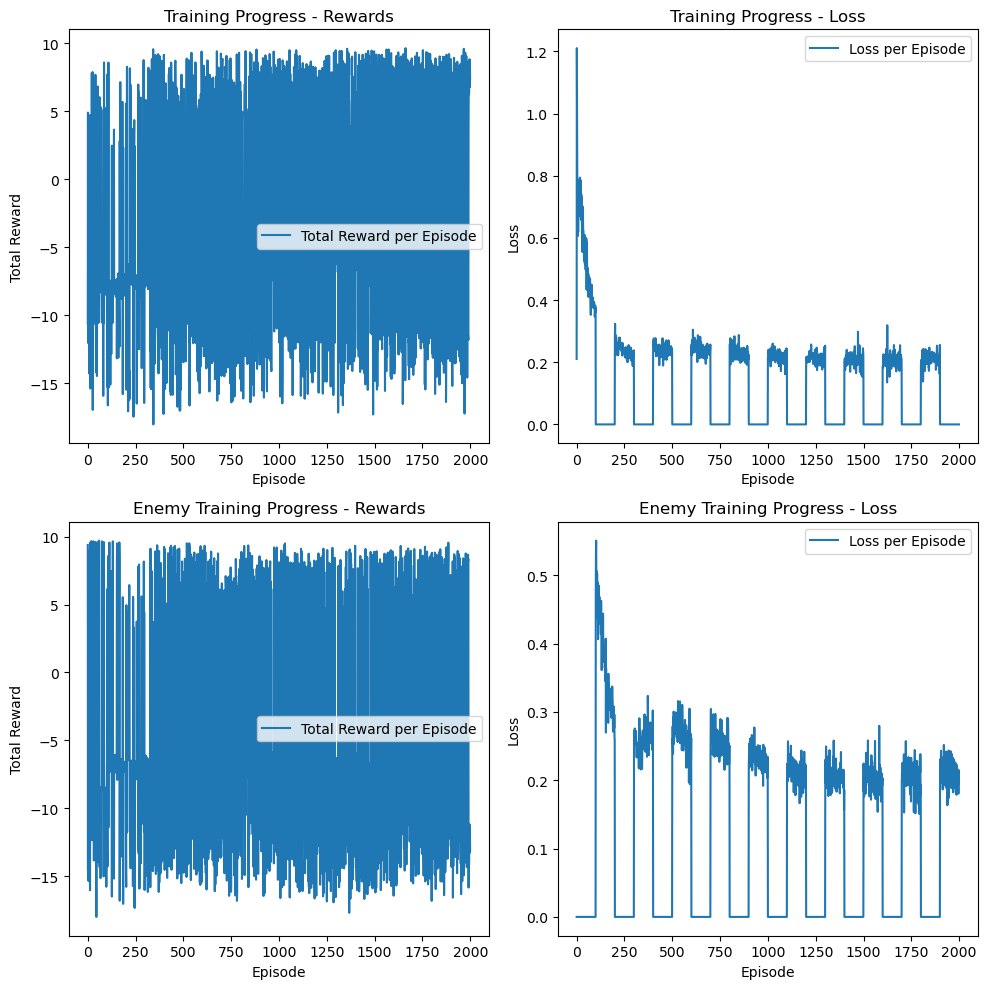

100%|██████████| 2000/2000 [39:02<00:00,  1.17s/it]

Episode 1999/2000, Total Reward: 7.359999999999999, epsilon: 0.01, beta: 0.9997 lr: 1.7433922005000008e-05
0 0.01
Path Efficiency Ratio: 0.32558139534883723


In [96]:
GOAL_REWARD = 10
FAIL_PENALTY = -10
ENEMY_REWARD = 10
MOVE_PENALTY = - 0.1

MAX_BONUS = 0.05
BONUS_GROWTH =  0.01

SEED = 42  
NUM_OBSTACLES = 10
SIZE = 10

EPISODE_LENGTH = 100
EPISODES = 2_000

BUFFER_SIZE = 100_000

BATCH_SIZE = 64
LEARNING_RATE = 5e-5

EPSILON_DECAY = 0.95 # 0.995
EPSILON_MIN = 0.01
GAMMA = 0.9

env = AdversarialEnvironment(
    width = SIZE,
    height = SIZE, 
    move_penalty = MOVE_PENALTY, 
    goal_reward = GOAL_REWARD, 
    enemy_reward = ENEMY_REWARD, 
    fail_penalty = FAIL_PENALTY, 
    num_obstacles = NUM_OBSTACLES, 
    seed = SEED, 
    enhanced = True,
    max_bonus = MAX_BONUS,
    bonus_growth = BONUS_GROWTH,
    mobile_goal = True,
    enemy_enalbled = True,
    fully_competitive = False
)

agents = DQNAgents(
    state_size = len(env.get_state()),
    action_size = len(actions),
    epsilon_decay = EPSILON_DECAY,
    learning_rate = LEARNING_RATE,
    gamma = GAMMA,
    buffer_size = BUFFER_SIZE,
    epsilon_min = EPSILON_MIN, 
    indipendent_learning = True,
    prioritized = True,
    enemy_enabled = env.enemy_enabled
)

train_agent(
    env, agents,
    num_episodes = EPISODES,
    max_steps = EPISODE_LENGTH, 
    batch_size = BATCH_SIZE,
    render = False, 
    prioritized_replay = agents.memory.prioritized,
)

Test the agents 

In [102]:
from tqdm import tqdm
test_rewards = []
test_times = []
eval_episodes = 10
reached_goal = 0
enemy_catches = 0   

for episode in tqdm(range(eval_episodes)):
    time = 0
    test_episode_reward = 0
    state, _ , done = env.reset()
    
    while not done and time < EPISODE_LENGTH:

        agent_action = agents.act_agent(state)
        if env.enemy_enabled:
            enemy_action = agents.act_enemy(state)
        else:
            enemy_action = None

        _,next_state, reward,enemy_reward,_, done = env.step(agent_action, enemy_action, goal_distance_penalty = False)

        state = next_state

        test_episode_reward += reward     
        time+=1

        if done:
            if env.agent_pos == env.goal_pos:
                reached_goal += 1
            if env.enemy_enabled and env.agent_pos == env.enemy_pos:
                enemy_catches += 1
                
        env.render(pause = 0.1, text= f"Reward: {reward}, Enemy reward:{enemy_reward}", save_gif = True)
    
    test_rewards.append(test_episode_reward)
    test_times.append(time)
    env.save_gif(f"final_test4.gif", fps = 5)

100%|██████████| 10/10 [01:07<00:00,  6.79s/it]


Average reward: -0.6083999999999987
55
33


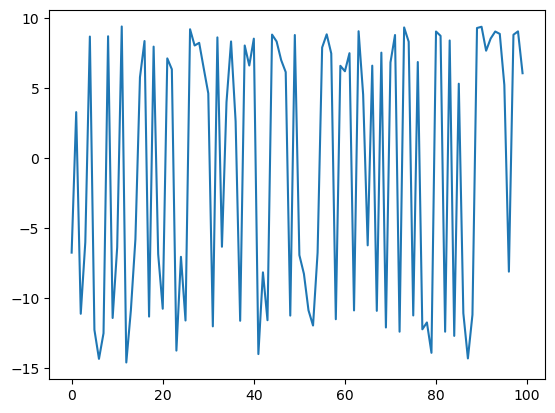

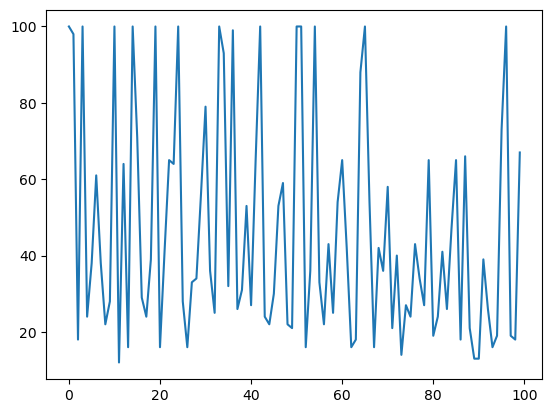

In [101]:
# Calculate and print average reward
avg_test_reward = sum(test_rewards) / len(test_rewards)
print("Average reward:", avg_test_reward)
avg_test_times = sum(test_times) / len(test_times)
print("Average times:", avg_test_times)
print(f"The agent reached the goal {reached_goal} times over {eval_episodes} episodes")
if env.enemy_enabled:
    print(f"The enemy caught the agent {enemy_catches} times over {eval_episodes} episodes")
plt.figure()
plt.plot(test_rewards)
plt.figure()
plt.plot(test_times)
plt.show()

Save the model is it was good

In [61]:
# Save the model
if agents.learning_type == 'global':
    torch.save(agents.policy_network.state_dict(), "global_model.pth")
else:
    torch.save(agents.agent_policy_network.state_dict(), "agent_model.pth")
    if env.enemy_enabled:
        torch.save(agents.enemy_policy_network.state_dict(), "enemy_model.pth")
